In [123]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem, FakeJakarta, FakeGuadalupe

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

In [124]:
backend = FakeGuadalupe()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 8

STEPS = 10

In [125]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy
from tqdm import tqdm

def generate_data(generating_func, save_path, J_list, run_config_n, pauli_list):
    entries = []
    # J_list = tqdm(enumerate(J_list), total=len(J_list))
    J_list = enumerate(J_list)
    for i, J in J_list:
        for meas_basis in tqdm(pauli_list):
            circuit_before_trans, circuit = generating_func(J, meas_basis, STEPS)

            obs = np.array(list(meas_basis))
            marginal_over = np.where(obs == 'I')[0].tolist() if 'I' in obs else None
            # print(meas_basis, marginal_over)

            ideal_exp_val = get_all_z_exp_wo_shot_noise(circuit_before_trans, marginal_over=marginal_over)

            job_noisy = execute(circuit, **run_config_n)
            counts_noisy = job_noisy.result().get_counts()
            noisy_exp_val = cal_all_z_exp(counts_noisy, marginal_over=marginal_over)

            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=[ideal_exp_val],
                noisy_exp_values=[[noisy_exp_val]],
                circuit_depth=circuit.depth()
            )
            to_append = entry.to_dict()
            to_append['circuit'] = circuit
            to_append['meas_basis'] = meas_basis
            to_append['J'] = J
            entries.append(to_append)

    path = f"{save_path}/step_{STEPS}_q{num_qubit}.pk"
    with open(path, "wb") as f:
        pickle.dump(entries, f)

In [126]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = num_qubit
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        for i, pauli in enumerate(ops['measure_basis']):
            if pauli in 'ZI':
                pass
            elif pauli == 'X':
                qc.x(i)
            elif pauli == 'Y':
                qc.sdg(i)
                qc.h(i)
            else:
                raise Exception("Must be X Y Z or I")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [127]:
# cls = IsingModel
# ops = cls.Options()
# ops.config_4q_paper()
# ops.update({'J': Parameter('J'), 'h': Parameter('h')})
# qc = cls.make_circs_sweep(ops, 1, 'XXYZ'), list(range(4))
# qc[0].draw('mpl', fold=-1)

# Random Ising Init

[3]


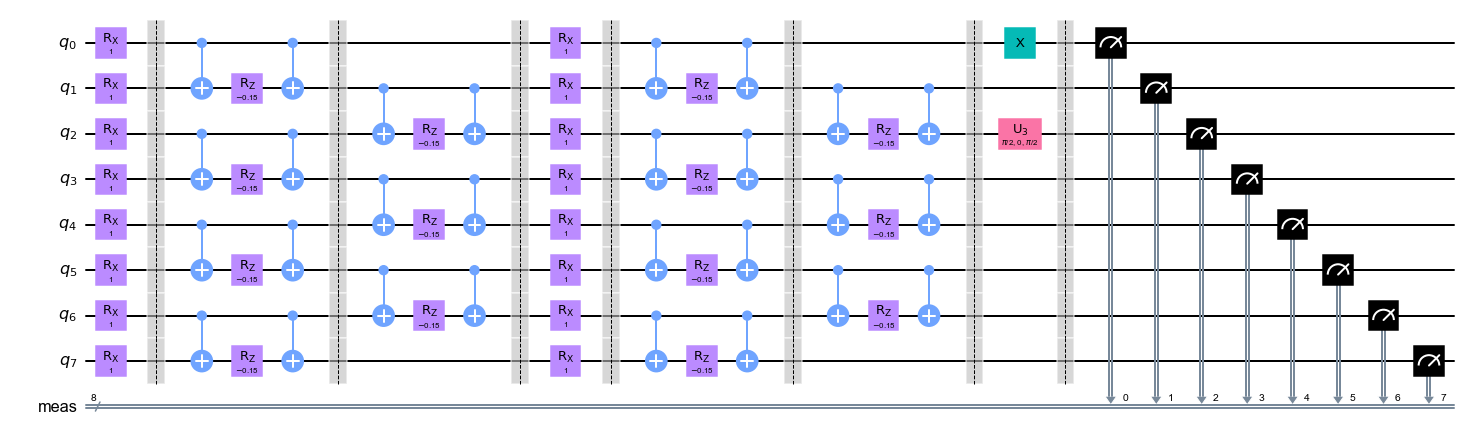

In [128]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def construct_ising_circuit_qasm_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    # qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    # qc_init.barrier()
    # qc = qc_init.compose(cls.make_circs_sweep(ops, num_steps, basis), list(range(4)))
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

J = 0.15
basis = 'XZYI'  # non-endian
obs = np.array(list(basis))
marginal_over = np.where(obs == 'I')[0].tolist() if 'I' in obs else None
print(marginal_over)
random_ising = construct_ising_circuit_qasm_init(J, basis, 2)
trans_circuit = transpile(random_ising, backend=backend_ideal, optimization_level=3)
trans_circuit.draw('mpl', fold=-1)

In [ ]:
exp_vals = []
N = 500
for _ in tqdm(range(N)):
    job_from_counts = execute(trans_circuit, **run_config_ideal)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts, marginal_over=marginal_over)]
print(sum(exp_vals) / N)

 27%|██▋       | 136/500 [00:07<00:19, 19.03it/s]

In [ ]:
from qiskit.result import marginal_counts
def get_all_z_exp_wo_shot_noise(circuit, marginal_over=None):
    circuit_copy = circuit.copy()
    circuit_copy.remove_final_measurements()
    circuit_copy.save_density_matrix()

    def int_to_bin(n, num_bits=4):
        if n < 2**num_bits:
            binary_str = bin(n)[2:]
            return binary_str.zfill(num_bits)
        else:
            raise ValueError

    job = execute(circuit_copy, QasmSimulator(), backend_options={'method': 'statevector'})
    probs = np.real(np.diag(job.result().data()['density_matrix']))
    probs = {int_to_bin(i, num_bits=num_qubit): p for i, p in enumerate(probs)}

    if marginal_over:
        probs = marginal_counts(probs, indices=marginal_over)

    exp_val = 0
    for key, prob in probs.items():
        num_ones = key.count('1')
        exp_val += (-1) ** num_ones * prob

    return exp_val

get_all_z_exp_wo_shot_noise(random_ising, marginal_over=marginal_over)

In [ ]:
import itertools
np.random.seed(0)
pauli_list_full = [''.join(s) for s in itertools.product(['X','Y','Z','I'], repeat=num_qubit)]
np.random.shuffle(pauli_list_full)
sep = 512
train_paulis = pauli_list_full[:sep]
test_paulis = pauli_list_full[sep:]
print(len(train_paulis), len(test_paulis))

In [ ]:
def construct_ising_circuit_qasm_init_tomo_func(J, basis, num_steps, be):
    random_ising = construct_ising_circuit_qasm_init(J, basis, num_steps)
    trans_circuit = transpile(random_ising, backend=be, optimization_level=3)
    return random_ising, trans_circuit

In [ ]:
# np.random.seed(0)
# h = 1
# J_list = np.random.uniform(0, h, size=1)
# plt.style.use({'figure.facecolor':'white'})
# plt.scatter(J_list, [0]*100);

In [ ]:
J_list = [0.15]

In [ ]:
generate_data(
    partial(construct_ising_circuit_qasm_init_tomo_func, be=backend_noisy),
    save_path='./data/ising_init_from_qasm_tomo',
    J_list=J_list,
    run_config_n=run_config_noisy,
    pauli_list=pauli_list_full,
)

In [ ]:
# generate_data(
#     partial(construct_ising_circuit_qasm_init_tomo_func, be=backend_noisy),
#     save_path='./data/ising_init_from_qasm_tomo',
#     J_list=J_list,
#     run_config_n=run_config_noisy,
#     pauli_list=test_paulis,
# )